# Neural Networks II

### References
- [Math for Machine Learning: Multivariate Calculus](https://www.coursera.org/learn/multivariate-calculus-machine-learning)
- [Stepic. Нейронные сети](https://stepik.org/course/401)
- [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)

![Test](images/nn_brains.png)

In [31]:
# Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [32]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [33]:
# Make plots bigger
scale = 2
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] *= scale
fig_size[1] *= scale

## Recap

![](images/nn_in_out_simple.png)

- summatory function ?
- activation function ?
- cost function ?
- what are the parameters of neural network?
- what is behind training?
- aggression? 

## Activation Functions

### Sigmoid

In [34]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

### Tanh

In [ ]:
def tanh(z):
    return numpy.tanh(z)

def tanh_prime(z):
    return 1. - z * z

### RELU

In [ ]:
def relu(z):
    return z * (z > 0)

def relu_prime(z):
    return 1. * (z > 0)

### Softmax

In [ ]:
def softmax_unstable(z):
    """The sigmoid function."""
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores)

def softmax(z):
    exps = np.exp(z - np.max(z))
    return exps / np.sum(exps)

## Loss Functions (Cost)

### Quadratic 

In [187]:
def loss_quadratic(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return 0.5 * (output_activations-y)**2

def loss_quadratic_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

### Cross-Entropy

In [ ]:
def loss_cross_entropy(a, y):
    """Return the cost associated with an output ``a`` and desired output
    ``y``.  Note that np.nan_to_num is used to ensure numerical
    stability.  In particular, if both ``a`` and ``y`` have a 1.0
    in the same slot, then the expression (1-y)*np.log(1-a)
    returns nan.  The np.nan_to_num ensures that that is converted
    to the correct value (0.0).
    
    https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network2.py#L45
    """
    a_ = softmax(a)
    return np.sum(np.nan_to_num(-y*np.log(a_)-(1-y)*np.log(1-a_)))

def loss_cross_entropy_derivative(z, a, y):
    """Return the error delta from the output layer.  Note that the
    parameter ``z`` is not used by the method.  It is included in
    the method's parameters in order to make the interface
    consistent with the delta method for other cost classes.
    
    https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network2.py#L57
    """
    return (a-y)

## Offtop

![](images/mvp.png)

### Neural Network (Advanced Numpy Implementation)

- Refactored code from **Neural Networks Basics I**

[NeuralNetworksAndDeepLearning](https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network2.py)

In [188]:
class NetworkBasic(object):
    """
    https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network2.py
    """

    def __init__(self, sizes, 
                 activation=sigmoid,
                 activation_derivative=sigmoid_prime,
                 cost=loss_quadratic,
                 cost_derivative=loss_quadratic_derivative):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
        self.activation = activation
        self.activation_derivative = activation_derivative
        self.cost = cost
        self.cost_derivative = cost_derivative

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            # weights (out_neurons x in_neurons)
            # biases (out_neurons x 1)
            # a (in_neurons x 1) -> vector
            # weights @ a -> (out_neurons x 1)
            # z = weights @ a + b -> (out_neurons x 1)
            # print(w.shape, "@", a.shape, "+", b.shape)
            z = w @ a + b
            a = self.activation(z)
        return a
    
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``
        
        Why nabla? https://en.wikipedia.org/wiki/Nabla_symbol
        ."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        #  ************** feedforward ********************
        a = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        
        for b, w in zip(self.biases, self.weights):
            z = w @ a + b 
            a = self.activation(z)
            zs.append(z)
            activations.append(a)
            
        # ************* backward pass *********************
        
        # a (in_neurons, 1)
        # y (out_neurons, 1) -> T
        # z (out_neurons, 1)
        # delta (out_neurons, 1)
        # print("x ", x.shape, "a ", activations[-1].shape, "y ", y.T.shape, "z ", z.shape)
        
        # delta (out_neurons, 1)
        # dC/da * da/dz
        
        # updating cost
        # self.costs_history.append(self.cost(a, y))
        
        delta = self.cost_derivative(a, y) * self.activation_derivative(z)
        # print("delta ", delta.shape)
        
        # dC/da * da/dz * dz/db (=1)
        assert nabla_b[-1].shape == delta.shape, f"nabla_b {nabla_b[-1].shape}, delta {delta.shape}"
        nabla_b[-1] = delta * 1
        
        # print(nabla_w[-1].shape, delta.shape, layer_input.shape)
        # dC/da * da/dz * dz/dw (=activation of previous layer)
        nabla_w[-1] = delta @ activations[-2].T 
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            
            # dzn/da_n-1 * dan/dzn
            delta = self.weights[-l+1].T @ delta * self.activation_derivative(zs[-l])
            # print(nabla_b[-l].shape, delta.shape)
            # print(nabla_w[-l].shape, delta.shape, activations[-l-1].shape)
            
            # dzn/da_n-1 * dan/dzn * dzn/db
            nabla_b[-l] = delta
            
            # dzn/da_n-1 * dan/dzn * dzn/dw (=activations of previous layer)
            nabla_w[-l] = delta @ activations[-l-1].T
        return (nabla_b, nabla_w)
    
    def train(self, training_data, epochs, learning_rate=10e-5, **kwargs):
        """The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory. """
            
        for j in range(epochs):
            self.update(training_data, learning_rate)
            
    
    def update(self, training_data, learning_rate=10e-5):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        # initialize gradients
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # for each example in training data
        # update gradients
        for x, y in training_data:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # update weights, biases with calculcated gradients
        self.weights = [w - (learning_rate / len(training_data))* nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (learning_rate / len(training_data)) * nb
                       for b, nb in zip(self.biases, nabla_b)]

### Definition #1

- **epoch** -> one forward pass and one backward pass of all the training examples
- **weights, biases** -> parameters of Neural Network
- **learning rate** -> hyperparameter 

### How to be sure that we implemented it correct?

In [10]:
def fx(x):
    # return np.sin(w)
    return x ** 3 + x ** 2 + x

def fx_derivative_analytical(x):
    return 3 * x**2 + 2 * x + 1

By definition derivative is:

$$\frac{f(x + \Delta x) - f(x)}{\Delta x}$$

In [19]:
def fx_derivative_numerical(f, x, eps=10e-5):
    return (f(x + eps) - f(x)) / eps

In [20]:
x = 2
fx_derivative_analytical(x)

17

In [29]:
eps=10e-8
fx_derivative_numerical(fx, x, eps=eps)

17.000000678280003

In [28]:
assert fx_derivative_analytical(x) == fx_derivative_numerical(fx, x, eps=eps), \
     f"{fx_derivative_analytical(x)} != {fx_derivative_numerical(fx, x, eps=eps)}"

AssertionError: 17 != 16.999999985500835

1. Let's test our functions are working

In [171]:
X = np.array([[1, 2]]).T
Y = np.array([[1., 0., 0.]]).T  # one-hot encoded

print(f"X: {X.shape}")  # vector
print(f"Y: {Y.shape}")  # vector

X: (2, 1)
Y: (3, 1)


In [189]:
network = NetworkBasic([X.shape[0], Y.shape[0]])
print("Network sizes :", network.sizes)

Network sizes : [2, 3]


In [190]:
# Feed forward
y = network.feedforward(X)
print(f"y: {y.shape} \n\n {y}")

y: (3, 1) 

 [[0.31172571]
 [0.01511993]
 [0.29743505]]


In [191]:
nabla_b, nabla_w = network.backprop(X, Y)
print(f"nabla_b: {nabla_b} \n\n nabla_w: {nabla_w}")

nabla_b: [array([[-0.14767117],
       [ 0.00022516],
       [ 0.06215424]])] 

 nabla_w: [array([[-1.47671170e-01, -2.95342340e-01],
       [ 2.25155556e-04,  4.50311113e-04],
       [ 6.21542404e-02,  1.24308481e-01]])]


### Numerical Gradient Check

By definition partial derivative is:

$$\frac{\partial f}{\partial x_i} = \frac{f\left(x_1,\ldots,x_{i-1}, x_i + \Delta x, x_{i+1}, \ldots, x_d\right) - f\left(x_1,\ldots, x_d\right)}{\Delta x}.$$

**Note** in definition we use $\lim _{\Delta x\to 0}$! But if we take small enough $\Delta x$, than the limit wis going to be good enough

In other words,
- calculate cost function for initial weights, biases
- change single weight to some small value
- calculcate cost function again
- divide the difference between **(1)** and **(3)** by **small value** 


#### A little better way


Let calculate instead: 

$$\frac{f(x) - f(x + \Delta x)}{\Delta x}$$

the following  

$$\frac{f(x  + \Delta x) - f(x - \Delta x)}{2 \Delta x}$$

in other words let's step to both sides. In practice this method works better.

In [192]:
def compute_grad_numerically(network, x, y, cost=loss_quadratic, eps=10e-5):
    nabla_b = [np.zeros(b.shape, dtype=np.float32) for b in network.biases]
    nabla_w = [np.zeros(w.shape, dtype=np.float32) for w in network.weights]
        
    
    # Loop through each layer in network
    for l in range(0, network.num_layers - 1):
        
        # Weights check
        weights = network.weights[l]
        
        # save weights
        old_weights = weights.copy()
        
        w, h = weights.shape[:2][::-1]
        for i in range(h):
            for j in range(w):
                # save previous value
                old_value = weights[i, j].copy() 
                
                # calculate f(x + e)
                weights[i, j] = old_value + eps
                fx_plus_eps = cost(network.feedforward(x), y)
                
                # calculate f(x - e)
                weights[i, j] = old_value - eps
                fx_minus_eps = cost(network.feedforward(x), y)
                    
                # calculcate (f(x + e) - f(x - e)) / (2 * eps)
                num_grad = (fx_plus_eps - fx_minus_eps) / (2 * eps)
                nabla_w[l][i, j] = np.sum((fx_plus_eps - fx_minus_eps)) / (2 * eps)
                    
                # restore previous value
                weights[i, j] = old_value
        
        # check we don't broke out network
        assert np.allclose(weights, old_weights), "We broke network"
        
        
        # Biases check
        biases = network.biases[l] 
        
        # save biases
        old_biases = biases.copy()
        n = biases.shape[0]
        
        # Loop through all biases
        for i in range(n):
            # save previous value
            old_value = biases[i].copy() 
            
            # calculate f(x + e)
            biases[i] = old_value + eps
            fx_plus_eps = cost(network.feedforward(x), y)
                
            # calculate f(x - e)
            biases[i] = old_value - eps
            fx_minus_eps = cost(network.feedforward(x), y)
                
            # calculcate (f(x + e) - f(x - e)) / (2 * eps)
            nabla_b[l][i] = np.sum((fx_plus_eps - fx_minus_eps)) / (2 * eps)
                
            biases[i] = old_value # old_weight
            
        # check we don't broke out network
        assert np.allclose(biases, old_biases), "We broke network"
    
        
    return nabla_b, nabla_w  

- Let's try

In [193]:
eps = 10e-6
nabla_b_numerical, nabla_w_numerical = compute_grad_numerically(network, X, Y, eps=eps)

In [194]:
for nabla_b_, nabla_b_numerical_ in zip(nabla_b, nabla_b_numerical):
    assert (np.allclose(nabla_b_, nabla_b_numerical_, atol=eps))
    
for nabla_w_, nabla_w_numerical_ in zip(nabla_w, nabla_w_numerical):
    assert (np.allclose(nabla_w_, nabla_w_numerical_, atol=eps))

In [195]:
print(f"nabla_b: {nabla_b} \n\n nabla_b_numerical: {nabla_b_numerical}")

nabla_b: [array([[-0.14767117],
       [ 0.00022516],
       [ 0.06215424]])] 

 nabla_b_numerical: [array([[-0.14767116],
       [ 0.00022516],
       [ 0.06215424]], dtype=float32)]


In [196]:
print(f"nabla_w: {nabla_w} \n\n nabla_w_numerical: {nabla_w_numerical}")

nabla_w: [array([[-1.47671170e-01, -2.95342340e-01],
       [ 2.25155556e-04,  4.50311113e-04],
       [ 6.21542404e-02,  1.24308481e-01]])] 

 nabla_w_numerical: [array([[-1.4767116e-01, -2.9534233e-01],
       [ 2.2515556e-04,  4.5031111e-04],
       [ 6.2154241e-02,  1.2430848e-01]], dtype=float32)]


### ? Assignment (Why we have error there?)

#### To remember

- **relative error > 1e-2**: usually means the gradient is probably **wrong**

- **1e-2 > relative error > 1e-4** should make you feel **uncomfortable**

- **1e-4 > relative error** is **usually okay** for objectives with kinks. But if there are no kinks (e.g. use of tanh nonlinearities and softmax), then 1e-4 is too high.

- **1e-7 and less** you should **be happy**.

### Useful links
- [Introduction into Tensorflow with Deep Learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187)
- [What the idea behind Machine Learning](https://youtu.be/UxKbUwj5hmU)

### Explore Neural Networks

### IRIS Dataset


![flower](https://archive.ics.uci.edu/ml/assets/MLimages/Large53.jpg)

As a motivating example, consider the [iris flower dataset](https://archive.ics.uci.edu/ml/datasets/iris). The dataset consists
of 150 data points where each data point is a feature vector $\boldsymbol x \in \mathbb{R}^4$ describing the attribute of a flower in the dataset, the four dimensions represent 

1. sepal length in cm 
2. sepal width in cm 
3. petal length in cm 
4. petal width in cm 


and the corresponding target $y \in \mathbb{Z}$ describes the class of the flower. It uses the integers $0$, $1$ and $2$ to represent the 3 classes of flowers in this dataset.

0. Iris Setosa
1. Iris Versicolour 
2. Iris Virginica

In [84]:
from sklearn import neighbors, datasets
iris = datasets.load_iris()

In [85]:
print('data shape is {}'.format(iris.data.shape))
print('class shape is {}'.format(iris.target.shape))

data shape is (150, 4)
class shape is (150,)


In [86]:
X = iris.data[:, :2] # use first two version for simplicity
y = iris.target

In [87]:
print(X[:10])

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]]


In [91]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


#### Visualize data

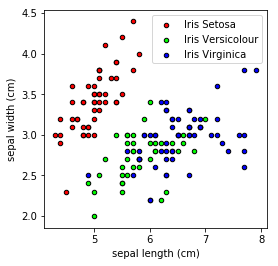

In [89]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000',  '#00FF00', '#0000FF'])

fig, ax = plt.subplots(figsize=(4,4))
for i, iris_class in enumerate(['Iris Setosa', 'Iris Versicolour', 'Iris Virginica']):
    idx = y==i
    ax.scatter(X[idx,0], X[idx,1], 
               c=cmap_bold.colors[i], edgecolor='k', 
               s=20, label=iris_class);
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')
ax.legend();

### ? What the problem with **Y**
- what last layer of Neural Network returns? 

### One-Hot-Encoding

In [92]:
def one_hot_encode(y: np.ndarray) -> np.ndarray:
    num_y = y.shape[0]
    n_classes = np.max(y) + 1    
    one_hot_encoded = np.zeros((num_y, n_classes))
    #empty one-hot matrix
    one_hot_encoded[np.arange(num_y), y] = 1
    return one_hot_encoded

In [93]:
Y = one_hot_encode(y)

In [94]:
for i in range(y.shape[0]):
    print(f"Before: {y[i]}, After: {Y[i]}")

Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, After: [1. 0. 0.]
Before: 0, Aft

In [95]:
print('data shape is {}'.format(X.shape))
print('class shape is {}'.format(Y.shape))
assert X.shape[0] == Y.shape[0]

data shape is (150, 2)
class shape is (150, 3)


### Data preparation

In [96]:
X = X[:, :, np.newaxis]  # add new dimension
Y = Y[:, :, np.newaxis]  # add new dimension

In [97]:
print('data shape is {}'.format(X.shape))
print('class shape is {}'.format(Y.shape))

data shape is (150, 2, 1)
class shape is (150, 3, 1)


In [98]:
training_data = [(X[i], Y[i]) for i in range(X.shape[0])]  # list of tuple X, Y

In [99]:
print(training_data[0][0].shape, training_data[0][1].shape)

(2, 1) (3, 1)


In [103]:
network = NetworkBasic([X.shape[1], Y.shape[1]])
total_cost = []

In [106]:
epochs = 1000
for i in range(epochs):
    network.update(training_data, learning_rate=0.1)
    
    total_cost.append(np.mean([network.cost(network.feedforward(x), y) \
                               for x, y in training_data]))
    
    if i % 10 == 0:
        print(f"Epoch {i} complete. Loss: {total_cost[-1]}")

Epoch 0 complete. Loss: 0.13810669420179267
Epoch 10 complete. Loss: 0.12729127214940564
Epoch 20 complete. Loss: 0.10547783221591332
Epoch 30 complete. Loss: 0.1001075491834199
Epoch 40 complete. Loss: 0.0997405283011246
Epoch 50 complete. Loss: 0.09956484498380587
Epoch 60 complete. Loss: 0.099398504136801
Epoch 70 complete. Loss: 0.09923734272799442
Epoch 80 complete. Loss: 0.09908108062800393
Epoch 90 complete. Loss: 0.09892952458499843
Epoch 100 complete. Loss: 0.09878249069588231
Epoch 110 complete. Loss: 0.0986398025769845
Epoch 120 complete. Loss: 0.0985012910981454
Epoch 130 complete. Loss: 0.09836679414576995
Epoch 140 complete. Loss: 0.098236156383147
Epoch 150 complete. Loss: 0.09810922900912923
Epoch 160 complete. Loss: 0.0979858695168876
Epoch 170 complete. Loss: 0.09786594145423147
Epoch 180 complete. Loss: 0.0977493141867463
Epoch 190 complete. Loss: 0.09763586266478555
Epoch 200 complete. Loss: 0.09752546719516277
Epoch 210 complete. Loss: 0.09741801321822519
Epoch 220

### ? What should we expect from cost after each epoch?

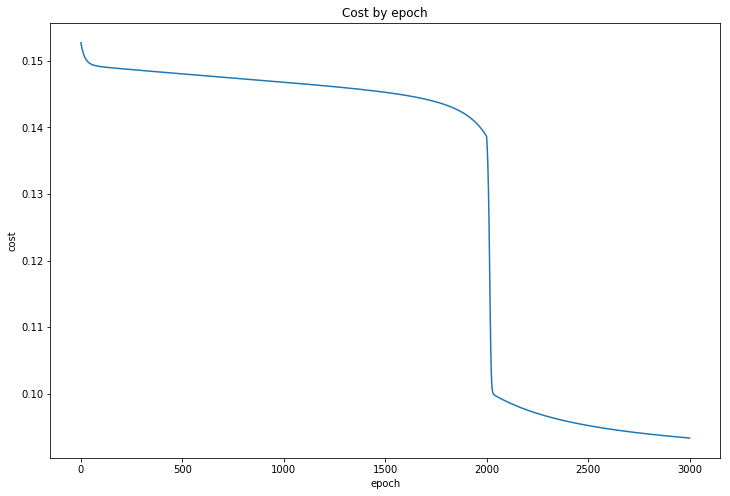

In [108]:
plt.plot(range(len(total_cost)), total_cost)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Cost by epoch")
plt.show()

### ? What the problem with previous graph ?

### Neural Network Evaluation

In [109]:
def evaluate(nnetwork, data):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    results = [(np.argmax(nnetwork.feedforward(x)), np.argmax(y))
                        for (x, y) in data]
    return sum(int(x == y) for (x, y) in results) / len(data)

In [115]:
network = NetworkBasic([X.shape[1], Y.shape[1]])
accuracy = []

In [116]:
epochs = 1000
for i in range(epochs):
    network.update(training_data, learning_rate=0.01)
    
    accuracy.append(evaluate(network, training_data))
    
    if i % 10 == 0:
        print(f"Epoch {i} complete. Accuracy: {accuracy[-1]}")

Epoch 0 complete. Accuracy: 0.3333333333333333
Epoch 10 complete. Accuracy: 0.3333333333333333
Epoch 20 complete. Accuracy: 0.3333333333333333
Epoch 30 complete. Accuracy: 0.3333333333333333
Epoch 40 complete. Accuracy: 0.3333333333333333
Epoch 50 complete. Accuracy: 0.3333333333333333
Epoch 60 complete. Accuracy: 0.3333333333333333
Epoch 70 complete. Accuracy: 0.3333333333333333
Epoch 80 complete. Accuracy: 0.3333333333333333
Epoch 90 complete. Accuracy: 0.3333333333333333
Epoch 100 complete. Accuracy: 0.3333333333333333
Epoch 110 complete. Accuracy: 0.3333333333333333
Epoch 120 complete. Accuracy: 0.3333333333333333
Epoch 130 complete. Accuracy: 0.3333333333333333
Epoch 140 complete. Accuracy: 0.3333333333333333
Epoch 150 complete. Accuracy: 0.3333333333333333
Epoch 160 complete. Accuracy: 0.3466666666666667
Epoch 170 complete. Accuracy: 0.36
Epoch 180 complete. Accuracy: 0.4266666666666667
Epoch 190 complete. Accuracy: 0.47333333333333333
Epoch 200 complete. Accuracy: 0.56
Epoch 210

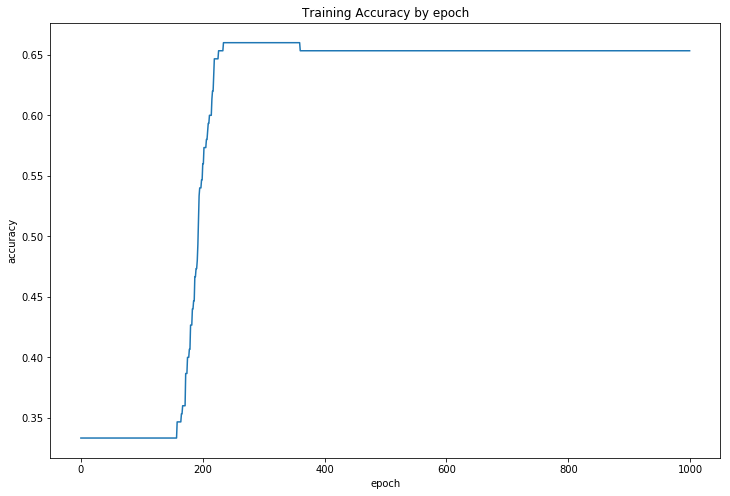

In [118]:
plt.plot(range(len(accuracy)), accuracy)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training Accuracy by epoch")
plt.show()

### ? What the problem with previous graph ?

### Train, Test, Validation

In [120]:
def split(training_data, train_rate=0.8):
    random.shuffle(training_data)
    n_train = int(len(training_data) * train_rate)
    return training_data[:n_train], training_data[n_train:]    

In [121]:
train_data, test_data = split(training_data, train_rate=0.8)

In [122]:
classes = ([np.argmax(y) for x, y in test_data])
print(f"Classes: {classes}, \nNum classes: {len(classes)}")

Classes: [1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 0, 2, 2, 0, 2, 1, 1, 2, 1], 
Num classes: 30


In [129]:
network = NetworkBasic([X.shape[1], 10, 10, Y.shape[1]])
accuracy = []

In [132]:
epochs = 1000
for i in range(epochs):
    network.update(train_data, learning_rate=0.1)
    
    accuracy.append(evaluate(network, test_data))
    
    if i % 100 == 0:
        print(f"Epoch {i} complete. Accuracy: {accuracy[-1]}")

Epoch 0 complete. Accuracy: 0.6
Epoch 100 complete. Accuracy: 0.6
Epoch 200 complete. Accuracy: 0.6
Epoch 300 complete. Accuracy: 0.5666666666666667
Epoch 400 complete. Accuracy: 0.5666666666666667
Epoch 500 complete. Accuracy: 0.5666666666666667
Epoch 600 complete. Accuracy: 0.5666666666666667
Epoch 700 complete. Accuracy: 0.6
Epoch 800 complete. Accuracy: 0.6
Epoch 900 complete. Accuracy: 0.6


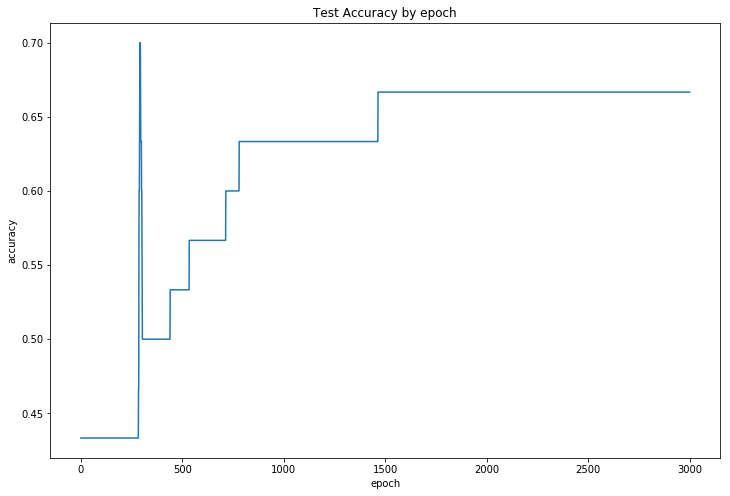

In [128]:
plt.plot(range(len(accuracy)), accuracy)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Test Accuracy by epoch")
plt.show()

### Best Practices

### Train, Test, Validation

![](images/train_valid_test.png)

### Under/Over fitting

In [133]:
network = NetworkBasic([X.shape[1], 10, 10, Y.shape[1]])

In [134]:
epochs = 1000
test_accuracy = []
train_accuracy = []
for i in range(epochs):
    network.update(train_data, learning_rate=0.1)
    
    test_accuracy.append(evaluate(network, test_data))
    train_accuracy.append(evaluate(network, train_data))
    
    if i % 100 == 0:
        print(f"Epoch {i} complete. Test Accuracy: {test_accuracy[-1]}, Train Accuracy: {train_accuracy[-1]}")

Epoch 0 complete. Test Accuracy: 0.3, Train Accuracy: 0.3416666666666667
Epoch 100 complete. Test Accuracy: 0.3, Train Accuracy: 0.3416666666666667
Epoch 200 complete. Test Accuracy: 0.4666666666666667, Train Accuracy: 0.5666666666666667
Epoch 300 complete. Test Accuracy: 0.5666666666666667, Train Accuracy: 0.6833333333333333
Epoch 400 complete. Test Accuracy: 0.5333333333333333, Train Accuracy: 0.675
Epoch 500 complete. Test Accuracy: 0.5, Train Accuracy: 0.6583333333333333
Epoch 600 complete. Test Accuracy: 0.5, Train Accuracy: 0.6583333333333333
Epoch 700 complete. Test Accuracy: 0.5333333333333333, Train Accuracy: 0.675
Epoch 800 complete. Test Accuracy: 0.5333333333333333, Train Accuracy: 0.675
Epoch 900 complete. Test Accuracy: 0.5333333333333333, Train Accuracy: 0.675


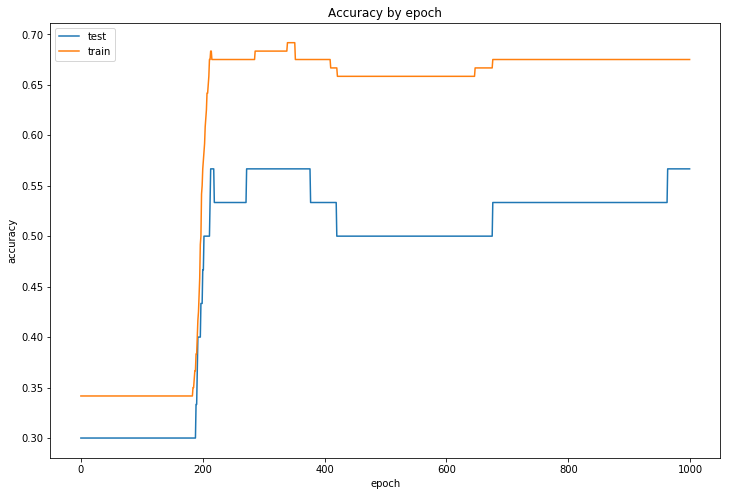

In [135]:
test_plot, = plt.plot(range(len(test_accuracy)), test_accuracy)
train_plot, = plt.plot(range(len(train_accuracy)), train_accuracy)
plt.legend([test_plot, train_plot], ['test', 'train'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy by epoch")
plt.show()

### Stochastic Gradient Descent

![](images/sgd.png)

In [138]:
class NetworkSGD(NetworkBasic):
    
    def __init__(self, sizes, 
                 activation=sigmoid,
                 activation_derivative=sigmoid_prime,
                 cost=loss_quadratic,
                 cost_derivative=loss_quadratic_derivative):
        
        NetworkBasic.__init__(self, 
                              sizes,
                              activation,
                              activation_derivative,
                              cost, 
                              cost_derivative)
        
    def train(self, training_data, epochs, 
            batch_size, learning_rate=10e-5):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory."""
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+batch_size] for k in xrange(0, n, batch_size)]
            for mini_batch in mini_batches:
                self._update(mini_batch, learning_rate)              
    

In [161]:
network = NetworkBasic([X.shape[1], 10, 10, Y.shape[1]])
test_accuracy = []
train_accuracy = []

In [162]:
epochs = 1000
batch_size = 10

learning_rate = 0.1
n = len(train_data)
for i in range(epochs):    
    random.shuffle(train_data)
    mini_batches = [
            train_data[k:k+batch_size] for k in range(0, n, batch_size)]
    for mini_batch in mini_batches:
        network.update(mini_batch, learning_rate)    
    
    test_accuracy.append(evaluate(network, test_data))
    train_accuracy.append(evaluate(network, train_data))
    
    if i % 100 == 0:
        print(f"Epoch {i} complete. Test Accuracy: {test_accuracy[-1]}, Train Accuracy: {train_accuracy[-1]}")

Epoch 0 complete. Test Accuracy: 0.3, Train Accuracy: 0.3416666666666667
Epoch 100 complete. Test Accuracy: 0.5666666666666667, Train Accuracy: 0.6833333333333333
Epoch 200 complete. Test Accuracy: 0.6666666666666666, Train Accuracy: 0.7083333333333334
Epoch 300 complete. Test Accuracy: 0.7, Train Accuracy: 0.75
Epoch 400 complete. Test Accuracy: 0.7, Train Accuracy: 0.75
Epoch 500 complete. Test Accuracy: 0.7, Train Accuracy: 0.7166666666666667
Epoch 600 complete. Test Accuracy: 0.7333333333333333, Train Accuracy: 0.75
Epoch 700 complete. Test Accuracy: 0.7666666666666667, Train Accuracy: 0.775
Epoch 800 complete. Test Accuracy: 0.8, Train Accuracy: 0.7833333333333333
Epoch 900 complete. Test Accuracy: 0.7666666666666667, Train Accuracy: 0.7833333333333333


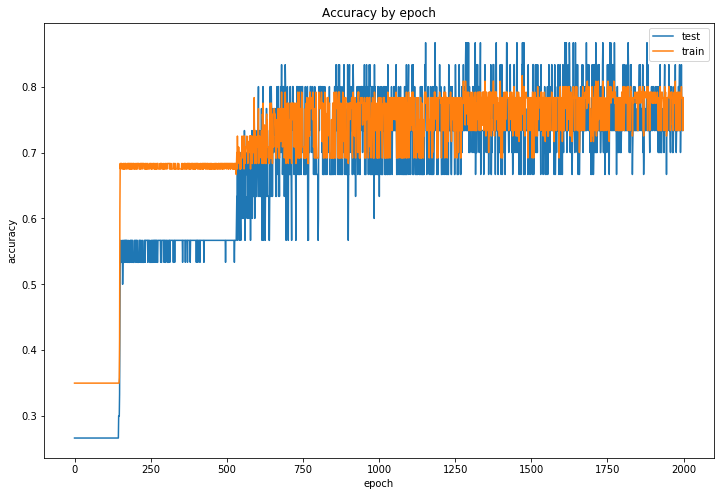

In [158]:
test_plot, = plt.plot(range(len(test_accuracy)), test_accuracy)
train_plot, = plt.plot(range(len(train_accuracy)), train_accuracy)
plt.legend([test_plot, train_plot], ['test', 'train'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy by epoch")
plt.show()

### ? SGD

### ?  Learning Rate

![](images/learningrates_clear.jpeg)

### Visualization

#### Heatmap

In [163]:
import seaborn as sns

Layer 0


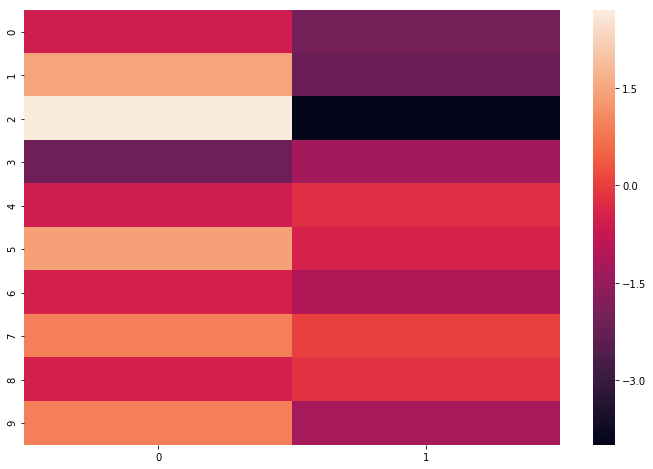

Layer 1


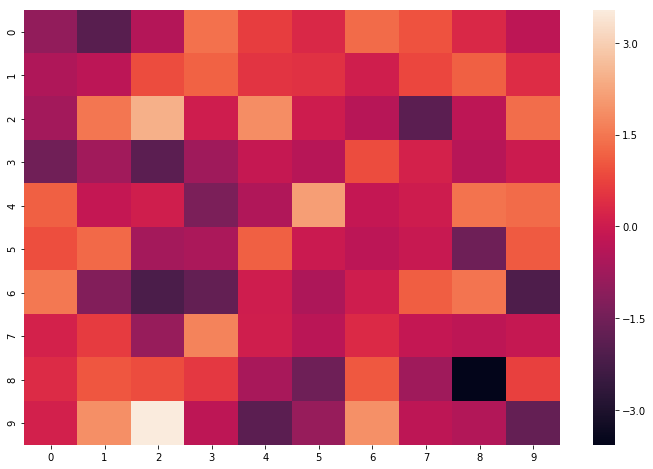

Layer 2


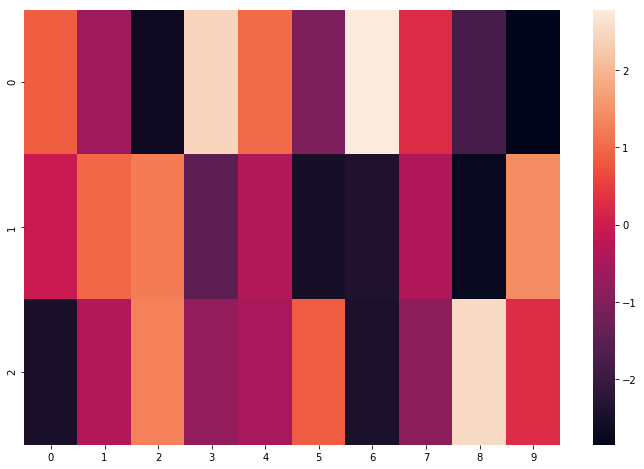

In [165]:
for i, w in enumerate(network.weights): 
    print(f"Layer {i}")
    sns.heatmap(w)
    plt.show()

[Hinton diagrams](https://matplotlib.org/gallery/specialty_plots/hinton_demo.html)

In [166]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

Layer 0


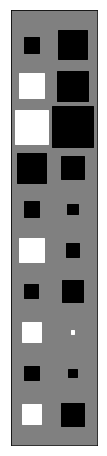

Layer 1


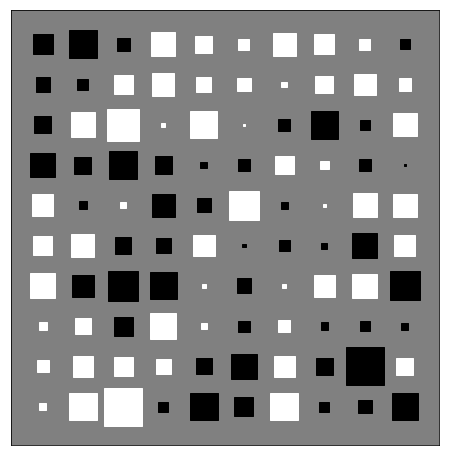

Layer 2


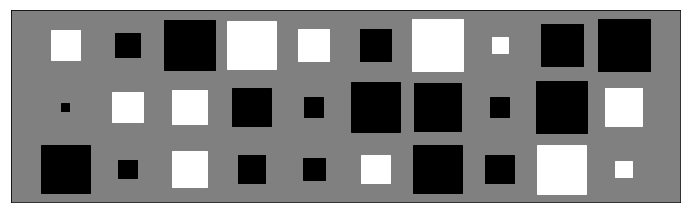

In [167]:
for i, w in enumerate(network.weights): 
    print(f"Layer {i}")
    hinton(w.T)
    plt.show()

### [Assignment](https://stepik.org/lesson/21780/step/1?unit=5198)
- Just Explore